In [1]:
import sys
sys.path.insert(0, '/Users/Soren/Documents/GitHub/sniffing-sensor')

seed = 42

In [2]:
from data.datasets import PureCompoundsInTallCuvettes
from data.sniffing_datasets import AlkanesShortSniff
from data.data_functions import DataLoader, PhaseTransform, DerivTransform, NormalizeTransform, NormalizePhaseTransform, SNIFFING_PATH

In [3]:
import numpy as np
import sqlite3
from sklearn.metrics import confusion_matrix

conn = sqlite3.connect("Sniffing-Sensor/Database/Sniffing-Sensor.db")
c = conn.cursor()

def classification_data(proc_num=2, compound_list=['ALL']):
    """ This function returns an array of phase values for specified chemicals, as well as the numeric labels (the OdorID). The function prompts the user for which chemicals they want to classify, and the user shall input comma separated values of the chemical names specified in the 'Odors' table in the sniffing-sensor database file. Else, the user can input 'all' and all of the chemicals under the chosen procedure will be trained and classified against one another.

    The function takes an optional parameter: 
        proc_num: the default value is 2, but the user can specify the procedure they want to classify.
        compound_list: a list of strings specifying the compounds to be imported, "ALL" compounds by default
        
    The function returns: 
        phase_datasets: the array of x-values.
        labels:         a list of the numeric labels
        compounds:      a list of the string labels

    """
    # x-data for interpolation (240 timesteps within 12 seconds)
    if proc_num == 2:
        xdata = np.linspace(0, 11.5, 230) # Procedure 2 is 11.5 seconds long
    elif proc_num == 3: 
        xdata = np.linspace(0, 12.5, 250) # Procedure 3 is 12.5 seconds long
    elif proc_num == 4: 
        xdata = np.linspace(0, 17, 340) # Procedure 4 is 17 seconds long
    elif proc_num == 5:
        xdata = np.linspace(0, 11, 220) # Procedure 5 is 11 seconds long

    # Compound dictionary
    compound_dict = {"WATER":    ["WATER"], 
                     "ETHANOL":  ["ETHANOL"], 
                     "IPA":      ["IPA"], 
                     "PENTANE":  ["PENTANE"], 
                     "HEXANE":   ["HEXANE"], 
                     "HEPTANE":  ["HEPTANE"], 
                     "OCTANE":   ["OCTANE"],
                     "NONANE":   ["NONANE"], 
                     "DECANE":   ["DECANE"],
                    }
    
    compounds = [name.upper().strip() for name in compound_list]
    
    datasets = {}
    
    if "ALL" in compounds:
        compounds = list(compound_dict)
        
    for compound in compounds:
        temp = c.execute("SELECT OdorID FROM Odors WHERE Name='%s'" %str(compound.upper())) # All database entries are uppercase
        Odor = c.fetchall()[0][0]
        c.execute(""" SELECT ExperimentID FROM Experiments WHERE OdorID='%i' 
                                                             AND ProcedureID='%s' 
                                                             AND NOTES != 'Skip'
                                                             AND NOTES != 'Validation' """ % (Odor, proc_num))
        data = c.fetchall()
        data = [i[0] for i in data] # Turns list of tuples into list of integers
        datasets[compound] = data
        #if '-' in compound: 
        #    labels.extend([int(compound[0])/10 for i in range(len(data))])
        #else: 
        #    labels.extend([Odor for i in range(len(data))])

    return datasets

classification_data()

{'WATER': [153, 156, 159, 162, 165, 168, 171, 174, 177, 180],
 'ETHANOL': [154, 157, 160, 163, 166, 169, 172, 175, 178, 181],
 'IPA': [152, 155, 158, 161, 164, 167, 170, 173, 176, 179],
 'PENTANE': [184, 187, 190, 193, 196, 199, 202, 205, 208, 211],
 'HEXANE': [183, 186, 189, 192, 195, 198, 201, 204, 207, 210],
 'HEPTANE': [182, 185, 188, 191, 194, 197, 200, 203, 206, 209],
 'OCTANE': [212, 215, 218, 221, 224, 227, 230, 233, 236, 239],
 'NONANE': [213, 216, 219, 222, 225, 228, 231, 234, 237, 240],
 'DECANE': [214, 217, 220, 223, 226, 229, 232, 235, 238, 241]}

In [ ]:
from data.datasets import Dataset

class AlkanesShortSniffAll(Dataset):
    def __init__(self):
        """Experiments used in the short sniffing plot for Alkanes."""
        exp_set = OrderedDict(
            [
                ("Pentane", [184, 187, 190, 193, 196, 199, 202, 205]),
                ("Hexane", [183, 186, 189, 192, 195, 198, 201, 204, 207]),
                ("Heptane", [182, 185, 188, 191, 194, 197, 200, 203, 206]),
                ("Octane", [212, 215, 218, 221, 224, 227, 230, 233, 236, 239]),
                ("Nonane", [213, 216, 219, 222, 225, 228, 231, 234, 237, 240]),
                ("Decane", [214, 217, 220, 223, 226, 229, 232, 235, 238, 241]),
            ]
        )
        super().__init__(exp_set)

In [ ]:
gas_phase, gas_labels = DataLoader(AlkanesShortSniff(), transforms=[PhaseTransform, NormalizePhaseTransform], folder=SNIFFING_PATH).load()
gas_derivs, _ = DataLoader(AlkanesShortSniff(), transforms=[DerivTransform, NormalizeTransform], folder=SNIFFING_PATH).load()

# Sniffing project analysis
Created by Sören Brandt (Fri, Mar 20, 2020 at 5:15pm)
##### The project uses function stored in analysis_functions.py

### IMPORT MODULES

In [159]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, metrics #datasets, svm, metrics
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV as gs

from sniffing_functions import plot_confusion_matrix

In [160]:
# list of experiments that for one reason or another are outliers
list_to_remove = [210,211]

### COMPARING PROCEDURES
This section compares data from several procedures for different chemicals

##### Pentane

In [161]:
import pandas as pd
import numpy as np
import sqlite3
from scipy.signal import savgol_filter as sgf
from scipy.interpolate import interp1d as interp
from sklearn.metrics import confusion_matrix
conn = sqlite3.connect("Database/Sniffing-Sensor.db")
c = conn.cursor()

In [162]:
def remove_outliers(obj,outliers=list_to_remove):
    for out in outliers:
        if out in obj:
            del obj[out]
            
        try:
            for key,values in obj.items():
                if out in values:
                    obj[key].remove(out)
        except:
            pass

In [163]:
import sys

def classification_data(proc_num=2, compound_list=['ALL']):
    """ This function returns an array of phase values for specified chemicals, as well as the numeric labels (the OdorID). The function prompts the user for which chemicals they want to classify, and the user shall input comma separated values of the chemical names specified in the 'Odors' table in the sniffing-sensor database file. Else, the user can input 'all' and all of the chemicals under the chosen procedure will be trained and classified against one another.

    The function takes an optional parameter: 
        proc_num: the default value is 2, but the user can specify the procedure they want to classify.
        compound_list: a list of strings specifying the compounds to be imported, "ALL" compounds by default
        
    The function returns: 
        phase_datasets: the array of x-values.
        labels:         a list of the numeric labels
        compounds:      a list of the string labels

    """
    # x-data for interpolation (240 timesteps within 12 seconds)
    if proc_num == 2:
        xdata = np.linspace(0, 11.5, 230) # Procedure 2 is 11.5 seconds long
    elif proc_num == 3: 
        xdata = np.linspace(0, 12.5, 250) # Procedure 3 is 12.5 seconds long
    elif proc_num == 4: 
        xdata = np.linspace(0, 17, 340) # Procedure 4 is 17 seconds long
    elif proc_num == 5:
        xdata = np.linspace(0, 11, 220) # Procedure 5 is 11 seconds long

    # Compound dictionary
    compound_dict = {"WATER":    ["WATER"], 
                     "ETHANOL":  ["ETHANOL"], 
                     "IPA":      ["IPA"], 
                     "PENTANE":  ["PENTANE"], 
                     "HEXANE":   ["HEXANE"], 
                     "HEPTANE":  ["HEPTANE"], 
                     "OCTANE":   ["OCTANE"],
                     "NONANE":   ["NONANE"], 
                     "DECANE":   ["DECANE"],
                    }
    
    compounds = [name.upper().strip() for name in compound_list]
    
    datasets = {}
    
    if "ALL" in compounds:
        compounds = list(compound_dict)
        
    for compound in compounds:
        temp = c.execute("SELECT OdorID FROM Odors WHERE Name='%s'" %str(compound.upper())) # All database entries are uppercase
        Odor = c.fetchall()[0][0]
        c.execute(""" SELECT ExperimentID FROM Experiments WHERE OdorID='%i' 
                                                             AND ProcedureID='%s' 
                                                             AND NOTES != 'Skip'
                                                             AND NOTES != 'Validation' """ % (Odor, proc_num))
        data = c.fetchall()
        data = [i[0] for i in data] # Turns list of tuples into list of integers
        datasets[compound] = data
        #if '-' in compound: 
        #    labels.extend([int(compound[0])/10 for i in range(len(data))])
        #else: 
        #    labels.extend([Odor for i in range(len(data))])
           
    
    phase_datasets = {}
    labels = {}
    
    n = 1
    N = sum([1 for values in list(datasets.values()) for value in values])
    for compound,values in datasets.items():
        for value in values:
            sys.stdout.write('{}/{}\r'.format(n,N))
            sys.stdout.flush()
            
            # update label
            labels[value] = compound

            # Specify folder of data
            folder = '../../Jupyter notebooks - Ethan/Gas Injection/Scan CSV Files/'

            ## Load data
            df = pd.read_csv(folder+'{}.csv'.format(value))
            df.drop('Unnamed: 0', axis=1, inplace=True)

            # Grab wavelengths between 400 and 900
            spectral_data = df.loc[(df['Wavelengths']>400) & (df['Wavelengths']<900), :]
            time = [float(i) for i in list(df.columns)[1:]]

            ## Calculate phase (using the lowest frequency)
            ft_data = np.fft.fft(spectral_data.drop('Wavelengths', axis=1).transpose())
            R = np.real(ft_data[:, 1])
            I = np.imag(ft_data[:, 1])

            phase = I / (R ** 2 + I ** 2) ** 0.5
            phase = sgf(phase, window_length=31, polyorder=3) # using savgol_filter as sgf
            phase = phase/np.sqrt(np.sum(phase**2)) # normalization

            # Interpolate
            f = interp(time, phase)#, fill_value="extrapolate") # using interp1d as interp
            phase_interp = f(xdata)

            # Re-Normalization
            norm_phase = (phase_interp-phase_interp.mean())/phase_interp.std()

            phase_datasets[value] = norm_phase
            
            # experiments done
            n+=1
    
    print('{}/{} done'.format(n-1,N))
        
    return phase_datasets, labels, datasets, xdata

In [164]:
from sklearn.model_selection import train_test_split

def plot_learning_curve(estimator, exp_derivs, exp_concentrations, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5, ax = None):
    if ax == None:
        fig, ax = plt.subplots()
    if M == None:
        M = np.arange(1,int(len(exp_derivs)*(1-test_size)))

    train_mean = []
    train_std = []
    test_mean = []
    test_std = []

    for m in M:
        train_score = []
        test_score = []
        for state in random_seeds:
            train_derivs, test_derivs, train_lbl, test_lbl = train_test_split(exp_derivs, exp_concentrations, test_size=test_size,random_state=state)
            derivs = train_derivs[0:m]
            lbls = train_lbl[0:m]
            if len(set(lbls)) < 2:
                continue
            if estimator != 'multi': # train SVR
                estimator.fit(derivs, lbls);
                score = estimator.score(test_derivs, test_lbl)
                
                if score > 0:
                    train_score.append(estimator.score(derivs, lbls))
                    test_score.append(estimator.score(test_derivs, test_lbl))
            else: # train multi-region SVR
                model = train_multiSVR(derivs, lbls, kernel=kernel, error_thresh = 0.07);
                score = calculate_R2(test_lbl,predict_multiSVR(model, test_derivs))
    
                if score > 0:
                    train_score.append(calculate_R2(lbls,predict_multiSVR(model, derivs)))
                    test_score.append(calculate_R2(test_lbl,predict_multiSVR(model, test_derivs)))

        train_mean.append(np.mean(train_score, axis=0))
        train_std.append(np.std(train_score, axis=0))
        test_mean.append(np.mean(test_score, axis=0))
        test_std.append(np.std(test_score, axis=0))

    ax.set_ylim(ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.fill_between(M , np.array(train_mean) - np.array(train_std),np.array(train_mean) + np.array(train_std), alpha=0.1,color="r")
    ax.fill_between(M, np.array(test_mean) - np.array(test_std),np.array(test_mean) + np.array(test_std), alpha=0.1, color="g")
    ax.plot(M, train_mean, 'o-', color="r",label="Training score")
    ax.plot(M, test_mean, 'o-', color="g",label="Cross-validation score")
    ax.grid()
    ax.legend(loc="lower right")

    print("Training accuracy: " + str(train_mean[-1]) + " (" + str(train_std[-1]) + ")")
    print("Validation accuracy: " + str(test_mean[-1]) + " (" + str(test_std[-1]) + ")")
    
    return test_mean, test_std, M

In [10]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD[2], num_to_lbl[2], lbls[2], time[2] = classification_data(2, compound_list=["Pentane"])
PD[3], num_to_lbl[3], lbls[3], time[3] = classification_data(3, compound_list=["Pentane"])
PD[4], num_to_lbl[4], lbls[4], time[4] = classification_data(4, compound_list=["Pentane"])
PD[5], num_to_lbl[5], lbls[5], time[5] = classification_data(5, compound_list=["Pentane"])

# Remove outliers
for ds in PD.values():
    remove_outliers(ds, list_to_remove)

10/10 done
10/10 done
10/10 done
0/0 done


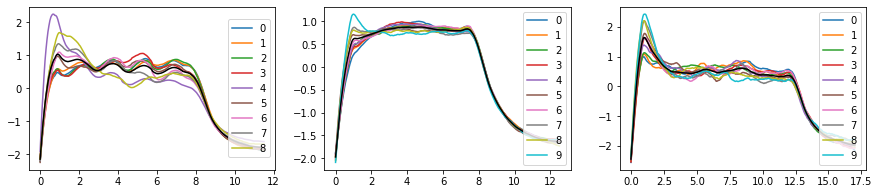

In [57]:
fig, ax = plt.subplots(ncols = 3)
fig.set_size_inches(15,3)

for n,proc in enumerate(range(2,5)):
    data = np.array(list(PD[proc].values()))

    ax[n].plot(time[proc], data.transpose())
    ax[n].plot(time[proc], np.mean(data,axis=0),'k')
    ax[n].legend(range(len(data)), loc='center right')

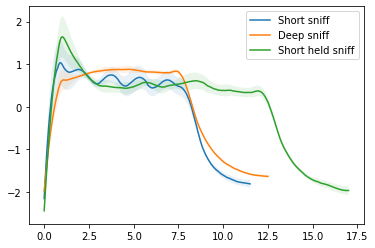

In [58]:
# ========== DISPLAY DATA ==========
for n,proc in enumerate(range(2,5)):
    data = np.array(list(PD[proc].values()))
    
    avg = np.mean(data,axis=0)
    std = np.std(data,axis=0)

    plt.plot(time[proc],avg)
    plt.fill_between(time[proc],avg-std,avg+std,alpha=0.1)

plt.legend(['Short sniff','Deep sniff','Short held sniff'])

##### Hexane

In [59]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD[2], num_to_lbl[2], lbls[2], time[2] = classification_data(2, compound_list=["Hexane"])
PD[3], num_to_lbl[3], lbls[3], time[3] = classification_data(3, compound_list=["Hexane"])
PD[4], num_to_lbl[4], lbls[4], time[4] = classification_data(4, compound_list=["Hexane"])
PD[5], num_to_lbl[5], lbls[5], time[5] = classification_data(5, compound_list=["Hexane"])

# Remove outliers
for ds in PD.values():
    remove_outliers(ds, list_to_remove)

10/10 done
10/10 done
10/10 done
0/0 done


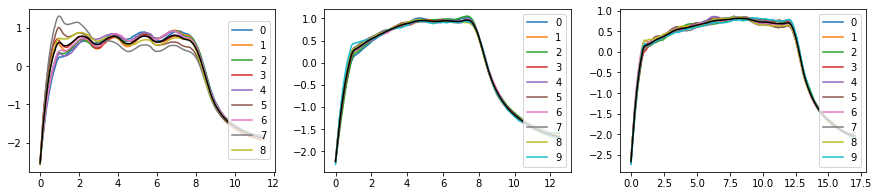

In [60]:
fig, ax = plt.subplots(ncols = 3)
fig.set_size_inches(15,3)

for n,proc in enumerate(range(2,5)):
    data = np.array(list(PD[proc].values()))

    ax[n].plot(time[proc], data.transpose())
    ax[n].plot(time[proc], np.mean(data,axis=0),'k')
    ax[n].legend(range(len(data)), loc='center right')

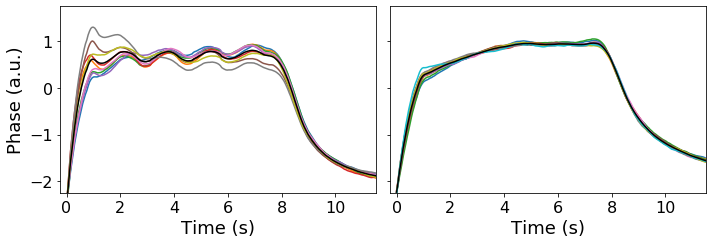

In [61]:
fig, ax = plt.subplots(ncols = 2, sharey=True)
fig.set_size_inches(10,3.5)

labelsize = 18
ticksize = 16

for n,proc in enumerate(range(2,4)):
    data = np.array(list(PD[proc].values()))

    ax[n].plot(time[proc], data.transpose())
    ax[n].plot(time[proc], np.mean(data,axis=0),'k')
    
    ax[n].set_xlabel('Time (s)', fontsize=labelsize)
    ax[n].tick_params(labelsize=ticksize)
    ax[n].set_xlim([-0.25,11.5])
    ax[n].set_xticks([0, 2, 4, 6, 8, 10])
    ax[n].set_ylim([-2.25,1.75])
ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_yticks([-2,-1,0,1])
    
plt.tight_layout()

#fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing Hexane - short vs deep.svg', format='svg', dpi=1200)

In [26]:
list(range(0,13,2))

[0, 2, 4, 6, 8, 10, 12]

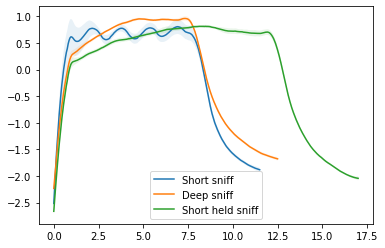

In [62]:
# ========== DISPLAY DATA ==========
for n,proc in enumerate(range(2,5)):
    data = np.array(list(PD[proc].values()))
    
    avg = np.mean(data,axis=0)
    std = np.std(data,axis=0)

    plt.plot(time[proc],avg)
    plt.fill_between(time[proc],avg-std,avg+std,alpha=0.1)

plt.legend(['Short sniff','Deep sniff','Short held sniff'])

##### Ethanol

In [13]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD[2], num_to_lbl[2], lbls[2], time[2] = classification_data(2, compound_list=["Ethanol"])
PD[3], num_to_lbl[3], lbls[3], time[3] = classification_data(3, compound_list=["Ethanol"])
PD[4], num_to_lbl[4], lbls[4], time[4] = classification_data(4, compound_list=["Ethanol"])
PD[5], num_to_lbl[5], lbls[5], time[5] = classification_data(5, compound_list=["Ethanol"])

# Remove outliers
for ds in PD.values():
    remove_outliers(ds, list_to_remove)

10/10 done
10/10 done
10/10 done
10/10 done


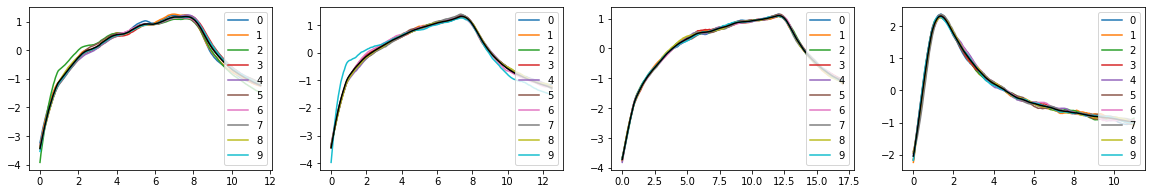

In [14]:
fig, ax = plt.subplots(ncols = 4)
fig.set_size_inches(20,3)

for n,proc in enumerate(range(2,6)):
    data = np.array(list(PD[proc].values()))

    ax[n].plot(time[proc], data.transpose())
    ax[n].plot(time[proc], np.mean(data,axis=0),'k')
    ax[n].legend(range(len(data)), loc='center right')

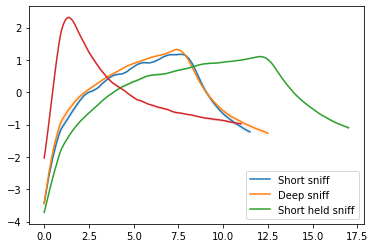

In [15]:
# ========== DISPLAY DATA ==========
for n,proc in enumerate(range(2,6)):
    data = np.array(list(PD[proc].values()))
    
    avg = np.mean(data,axis=0)
    std = np.std(data,axis=0)

    plt.plot(time[proc],avg)
    plt.fill_between(time[proc],avg-std,avg+std,alpha=0.1)

plt.legend(['Short sniff','Deep sniff','Short held sniff'])

### COMPARING PHASE BEHAVIOR
This section compares data from several polar and apolar compounds to see the effect of different procedures

##### Procedure 2: Short sniff
Odorant: 1,
Break: 0.5,
Repeat: 5,
Nitrogen: 5

In [11]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD['apolar'], num_to_lbl['apolar'], lbls['apolar'], time['apolar'] = classification_data(2, compound_list=["Pentane", "Hexane", "Heptane", "Octane", "Nonane", "Decane"])
PD['polar'], num_to_lbl['polar'], lbls['polar'], time['polar'] = classification_data(2, compound_list=["Water", "Ethanol", "IPA"])

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

60/60 done
30/30 done


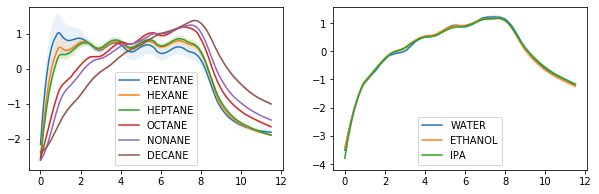

In [81]:
# ========== PLOT COMPARISON ==========
fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(10,3)

for n,compound in enumerate(PD):
    dataset = PD[compound]
    
    for chem,values in lbls[compound].items():
        if values:
            data = np.array([dataset[num] for num in values])

            avg = np.mean(data, axis=0)
            std = np.std(data, axis=0)

            ax[n].plot(time[compound], avg, label=chem)
            ax[n].fill_between(time[compound], avg-std, avg+std, alpha=0.1)

            ax[n].legend(loc='lower center')

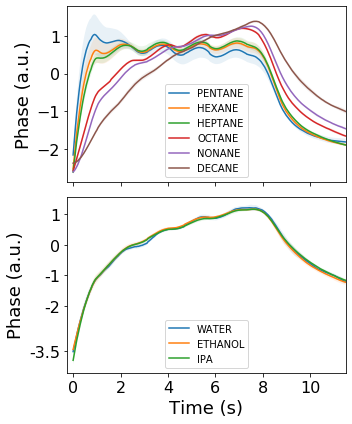

In [95]:
fig, ax = plt.subplots(nrows = 2, sharex=True)
fig.set_size_inches(5,6)

labelsize = 18
ticksize = 16

for n,compound in enumerate(PD):
    dataset = PD[compound]
    
    for chem,values in lbls[compound].items():
        if values:
            data = np.array([dataset[num] for num in values])

            avg = np.mean(data, axis=0)
            std = np.std(data, axis=0)

            ax[n].plot(time[compound], avg, label=chem)
            ax[n].fill_between(time[compound], avg-std, avg+std, alpha=0.1)

            ax[n].legend(loc='lower center')
    
    ax[n].set_ylabel('Phase (a.u.)', fontsize=labelsize)
    ax[n].tick_params(labelsize=ticksize)
    ax[n].set_xlim([-0.25,11.5])
    #ax[n].set_ylim([-2.25,1.75])
ax[0].set_yticks([-2,-1,0,1])
ax[1].set_yticks([-3.5,-2,-1,0,1])
ax[1].set_yticklabels([-3.5,-2,-1,0,1])
ax[1].set_xlabel('Time (s)', fontsize=labelsize)
ax[1].set_xticks([0, 2, 4, 6, 8, 10])
    
plt.tight_layout()

#fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing (a)polar - short.svg', format='svg', dpi=1200)

##### Procedure 3: Deep sniff
Odorant: 5,
Break: 2.5,
Nitrogen: 5

In [9]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD['apolar'], num_to_lbl['apolar'], lbls['apolar'], time['apolar'] = classification_data(3, compound_list=["Pentane", "Hexane", "Heptane", "Octane", "Nonane", "Decane"])
PD['polar'], num_to_lbl['polar'], lbls['polar'], time['polar'] = classification_data(3, compound_list=["Water", "Ethanol", "IPA"])

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

30/30 done
30/30 done


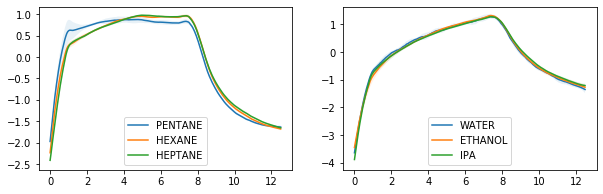

In [97]:
# ========== PLOT COMPARISON ==========
fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(10,3)

for n,compound in enumerate(PD):
    dataset = PD[compound]
    
    for chem,values in lbls[compound].items():
        if values:
            data = np.array([dataset[num] for num in values])

            avg = np.mean(data, axis=0)
            std = np.std(data, axis=0)

            ax[n].plot(time[compound], avg, label=chem)
            ax[n].fill_between(time[compound], avg-std, avg+std, alpha=0.1)

            ax[n].legend(loc='lower center')

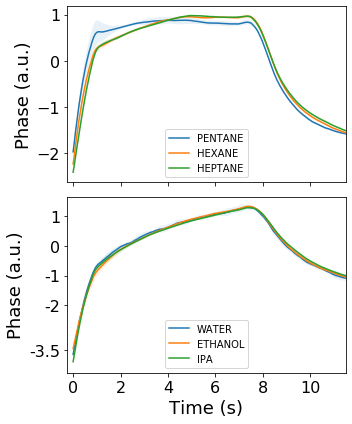

In [98]:
fig, ax = plt.subplots(nrows = 2, sharex=True)
fig.set_size_inches(5,6)

labelsize = 18
ticksize = 16

for n,compound in enumerate(PD):
    dataset = PD[compound]
    
    for chem,values in lbls[compound].items():
        if values:
            data = np.array([dataset[num] for num in values])

            avg = np.mean(data, axis=0)
            std = np.std(data, axis=0)

            ax[n].plot(time[compound], avg, label=chem)
            ax[n].fill_between(time[compound], avg-std, avg+std, alpha=0.1)

            ax[n].legend(loc='lower center')
    
    ax[n].set_ylabel('Phase (a.u.)', fontsize=labelsize)
    ax[n].tick_params(labelsize=ticksize)
    ax[n].set_xlim([-0.25,11.5])
    #ax[n].set_ylim([-2.25,1.75])
ax[0].set_yticks([-2,-1,0,1])
ax[1].set_yticks([-3.5,-2,-1,0,1])
ax[1].set_yticklabels([-3.5,-2,-1,0,1])
ax[1].set_xlabel('Time (s)', fontsize=labelsize)
ax[1].set_xticks([0, 2, 4, 6, 8, 10])
    
plt.tight_layout()

#fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing (a)polar - deep.svg', format='svg', dpi=1200)

##### Procedure 4: Short held sniff
Odorant: 3,
Hold: 3,
Odorant: 3,
Close: 3,
Nitrogen: 5

In [21]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD['apolar'], num_to_lbl['apolar'], lbls['apolar'], time['apolar'] = classification_data(4, compound_list=["Pentane", "Hexane", "Heptane", "Octane", "Nonane", "Decane"])
PD['polar'], num_to_lbl['polar'], lbls['polar'], time['polar'] = classification_data(4, compound_list=["Water", "Ethanol", "IPA"])

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

30/30 done
30/30 done


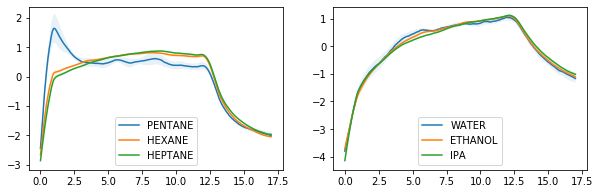

In [22]:
# ========== PLOT COMPARISON ==========
fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(10,3)

for n,compound in enumerate(PD):
    dataset = PD[compound]
    
    for chem,values in lbls[compound].items():
        if values:
            data = np.array([dataset[num] for num in values])

            avg = np.mean(data, axis=0)
            std = np.std(data, axis=0)

            ax[n].plot(time[compound], avg, label=chem)
            ax[n].fill_between(time[compound], avg-std, avg+std, alpha=0.1)

            ax[n].legend(loc='lower center')

##### Procedure 5: Short held exhale
Odorant: 1,
Nitrogen: 10

In [10]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
PD['apolar'], num_to_lbl['apolar'], lbls['apolar'], time['apolar'] = classification_data(5, compound_list=["Pentane", "Hexane", "Heptane", "Octane", "Nonane", "Decane"])
PD['polar'], num_to_lbl['polar'], lbls['polar'], time['polar'] = classification_data(5, compound_list=["Water", "Ethanol", "IPA"])

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

0/0 done
30/30 done


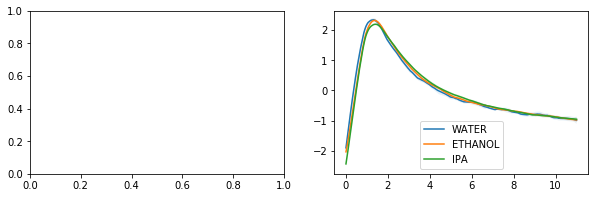

In [24]:
# ========== PLOT COMPARISON ==========
fig, ax = plt.subplots(ncols = 2)
fig.set_size_inches(10,3)

for n,compound in enumerate(PD):
    dataset = PD[compound]
    
    for chem,values in lbls[compound].items():
        if values:
            data = np.array([dataset[num] for num in values])

            avg = np.mean(data, axis=0)
            std = np.std(data, axis=0)

            ax[n].plot(time[compound], avg, label=chem)
            ax[n].fill_between(time[compound], avg-std, avg+std, alpha=0.1)

            ax[n].legend(loc='lower center')

### CLASSIFICATION OF COMPOUNDS (SVC)
This section loads a selection of compound measurements and performs several attempts at classification.
Compounds include: Water, Ethanol, IPA, Pentane, Hexane, Heptane, Octane, Nonane, Decane, and Toluene.

In [23]:
seed = 8

In [24]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
compounds = ["PENTANE", "HEXANE", "HEPTANE", "OCTANE", "NONANE", "DECANE"]#, "WATER", "ETHANOL", "IPA"]
PD[2], num_to_lbl[2], lbls[2], time[2] = classification_data(2, compound_list=compounds)
PD[3], num_to_lbl[3], lbls[3], time[3] = classification_data(3, compound_list=compounds)
PD[4], num_to_lbl[4], lbls[4], time[4] = classification_data(4, compound_list=compounds)

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

60/60 done
30/30 done
30/30 done


##### Procedure 2: Short sniff
Odorant: 1,
Break: 0.5,
Repeat: 5,
Nitrogen: 5

In [25]:
# ========== MACHINE LEARNING ==========

proc = 2

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Training accuracy: 1.0 (34)
Validation accuracy: 0.75 (24)


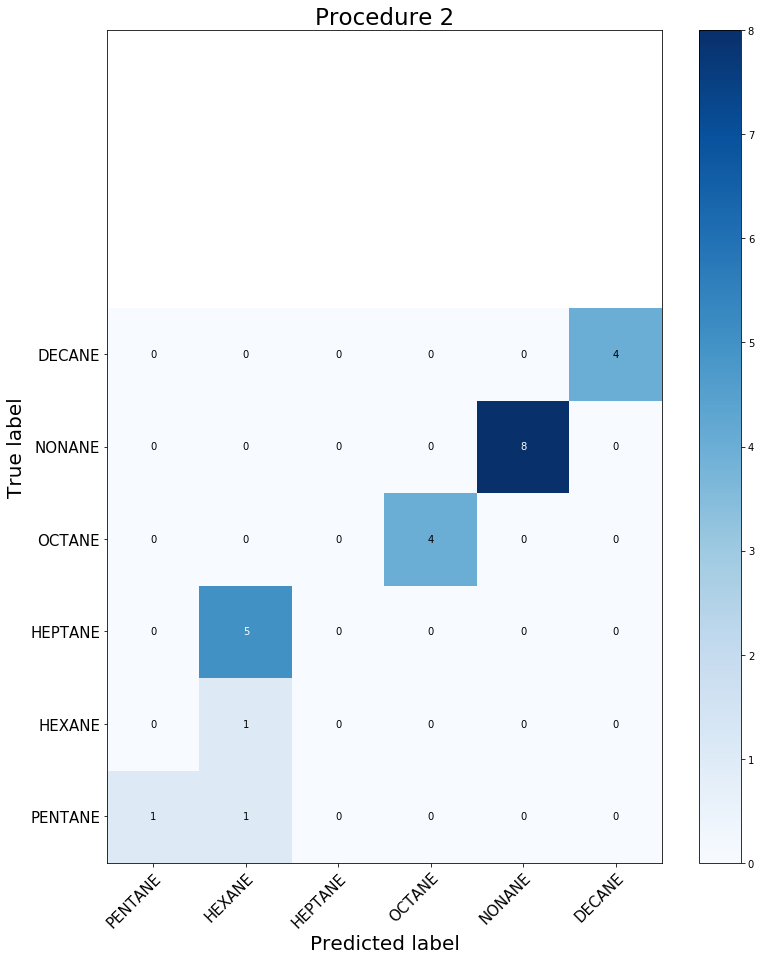

In [26]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 0.993921568627451 (0.009068494964586041)
Validation accuracy: 0.798611111111111 (0.06387379048648288)


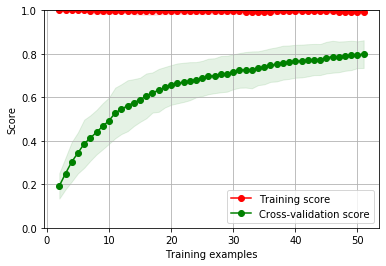

In [103]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

##### Procedure 3: Deep sniff
Odorant: 5,
Break: 2.5,
Nitrogen: 5

In [27]:
# ========== MACHINE LEARNING ==========

proc = 3

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (18)
Validation accuracy: 1.0 (12)


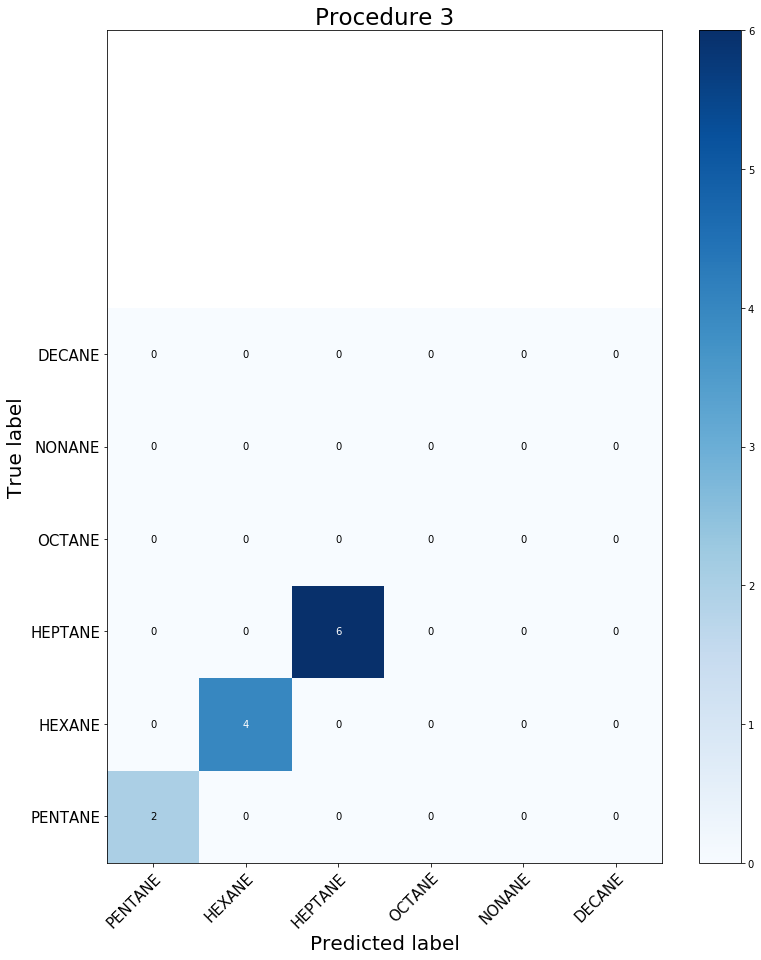

In [28]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 1.0 (0.0)
Validation accuracy: 0.9004166666666665 (0.05948126455728168)


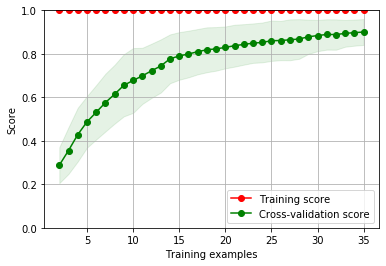

In [106]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

##### Procedure 4: Short held sniff
Odorant: 3,
Hold: 3,
Odorant: 3,
Close: 3,
Nitrogen: 5

In [182]:
# ========== MACHINE LEARNING ==========

proc = 4

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (36)
Validation accuracy: 0.8333333333333334 (24)


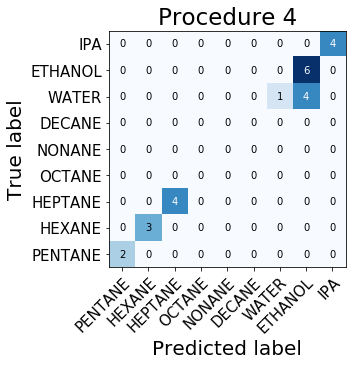

In [183]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 1.0 (0.0)
Validation accuracy: 0.8741666666666665 (0.05979711066970079)


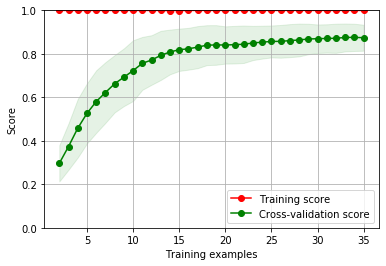

In [184]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

### CLASSIFICATION OF COMPOUNDS (SVC) - only apolar compounds
This section loads a selection of compound measurements and performs several attempts at classification.
Compounds include: Water, Ethanol, IPA, Pentane, Hexane, Heptane, Octane, Nonane, Decane, and Toluene.

In [167]:
seed = 1

In [195]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
compounds = ["PENTANE", "HEXANE", "HEPTANE", "OCTANE", "NONANE", "DECANE"]
PD[2], num_to_lbl[2], lbls[2], time[2] = classification_data(2, compound_list=compounds)
PD[3], num_to_lbl[3], lbls[3], time[3] = classification_data(3, compound_list=compounds)
PD[4], num_to_lbl[4], lbls[4], time[4] = classification_data(4, compound_list=compounds)

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

60/60 done
30/30 done
30/30 done


##### Procedure 2: Short sniff
Odorant: 1,
Break: 0.5,
Repeat: 5,
Nitrogen: 5

In [196]:
# ========== MACHINE LEARNING ==========

proc = 2

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (35)
Validation accuracy: 0.9583333333333334 (24)


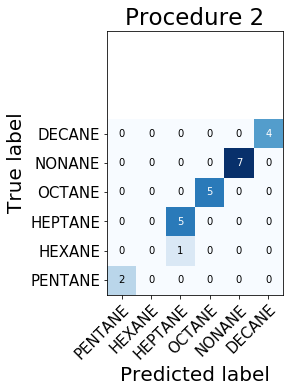

In [197]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 0.9955882352941177 (0.010502100630210075)
Validation accuracy: 0.8208333333333335 (0.08984941105353261)


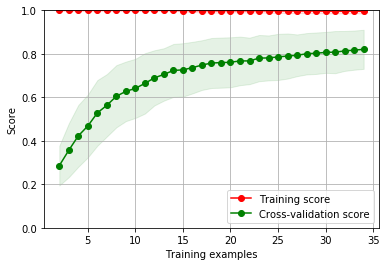

In [198]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

##### Procedure 3: Deep sniff
Odorant: 5,
Break: 2.5,
Nitrogen: 5

In [199]:
# ========== MACHINE LEARNING ==========

proc = 3

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (18)
Validation accuracy: 1.0 (12)


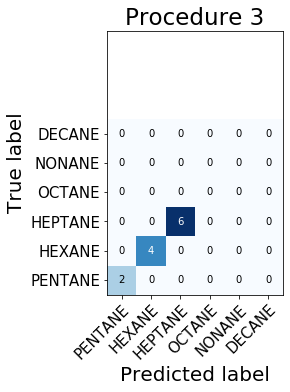

In [200]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 1.0 (0.0)
Validation accuracy: 0.9833333333333334 (0.04564354645876384)


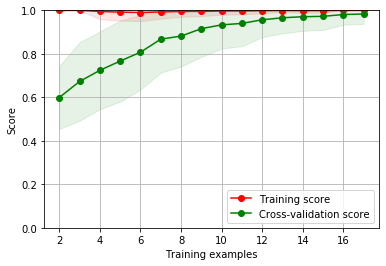

In [201]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

##### Procedure 4: Short held sniff
Odorant: 3,
Hold: 3,
Odorant: 3,
Close: 3,
Nitrogen: 5

In [202]:
# ========== MACHINE LEARNING ==========

proc = 4

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (18)
Validation accuracy: 0.9166666666666666 (12)


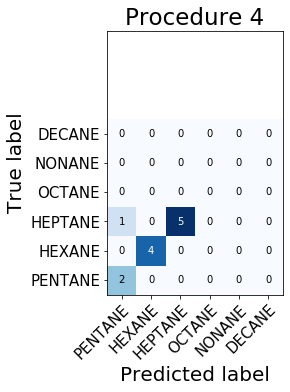

In [203]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 1.0 (0.0)
Validation accuracy: 0.9475000000000001 (0.07421346837932377)


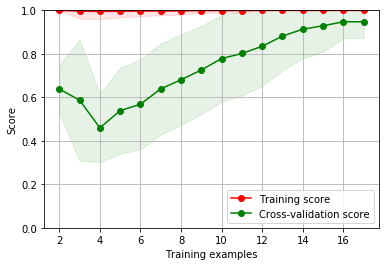

In [204]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

### CLASSIFICATION OF COMPOUNDS (SVC) - only polar compounds
This section loads a selection of compound measurements and performs several attempts at classification.
Compounds include: Water, Ethanol, IPA, Pentane, Hexane, Heptane, Octane, Nonane, Decane, and Toluene.

In [167]:
seed = 1

In [185]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
compounds = ["WATER", "ETHANOL", "IPA"]
PD[2], num_to_lbl[2], lbls[2], time[2] = classification_data(2, compound_list=compounds)
PD[3], num_to_lbl[3], lbls[3], time[3] = classification_data(3, compound_list=compounds)
PD[4], num_to_lbl[4], lbls[4], time[4] = classification_data(4, compound_list=compounds)

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

30/30 done
30/30 done
30/30 done


##### Procedure 2: Short sniff
Odorant: 1,
Break: 0.5,
Repeat: 5,
Nitrogen: 5

In [186]:
# ========== MACHINE LEARNING ==========

proc = 2

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (18)
Validation accuracy: 0.75 (12)


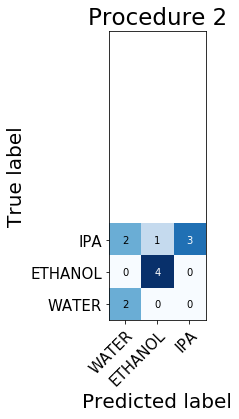

In [187]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 1.0 (0.0)
Validation accuracy: 0.7333333333333333 (0.17159383568311667)


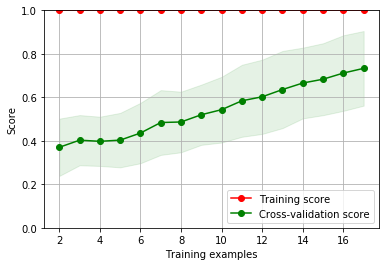

In [188]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

##### Procedure 3: Deep sniff
Odorant: 5,
Break: 2.5,
Nitrogen: 5

In [189]:
# ========== MACHINE LEARNING ==========

proc = 3

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (18)
Validation accuracy: 0.8333333333333334 (12)


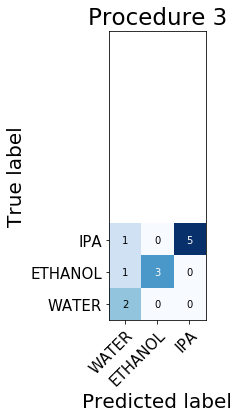

In [190]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 0.9988235294117647 (0.00823529411764706)
Validation accuracy: 0.8575 (0.10020465169952052)


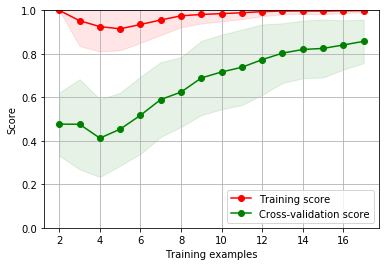

In [191]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

##### Procedure 4: Short held sniff
Odorant: 3,
Hold: 3,
Odorant: 3,
Close: 3,
Nitrogen: 5

In [192]:
# ========== MACHINE LEARNING ==========

proc = 4

data = list(PD[proc].values())
labels = list(num_to_lbl[proc].values())

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVC(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVC = clf.best_estimator_

# Perform training and testing
predicted = SVC.predict(test)

print("Training accuracy: {} ({})".format(round(SVC.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVC.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (18)
Validation accuracy: 0.8333333333333334 (12)


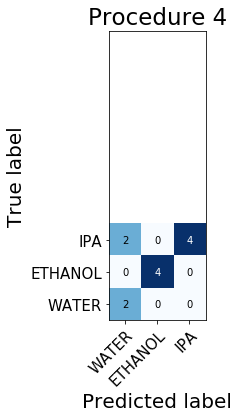

In [193]:
# ========== CONFUSION MATRIX ==========
plot_confusion_matrix(test_lbl, list(SVC.predict(test)), classes=compounds, title="Procedure {}".format(proc))
plt.ylim([-0.5,8.5]);

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Training accuracy: 1.0 (0.0)
Validation accuracy: 0.9391666666666667 (0.12352181543714812)


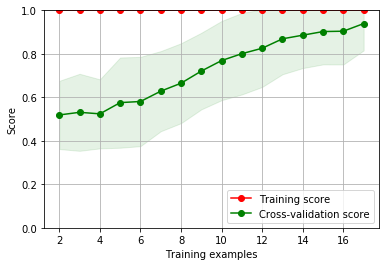

In [194]:
plot_learning_curve(SVC, data, labels, ylim=(0,1), random_seeds = np.arange(0,100), M = None, test_size = 1/2.5);

### REGRESSION OF MIXTURES (SVR)
This section loads a selection of compound measurements and performs several attempts at regression.
The mixtures that already exist in the database are: 
* Water+etoh
* pent+hex
* pent+oct

In [193]:
seed = 1

labelsize = 16
ticksize = 14

In [150]:
import sys

def regression_data(proc_num=2, mixture_list=['ALL']):
    """ This function returns an array of phase values for specified chemicals, as well as the numeric labels (the OdorID). The function prompts the user for which chemicals they want to classify, and the user shall input comma separated values of the chemical names specified in the 'Odors' table in the sniffing-sensor database file. Else, the user can input 'all' and all of the chemicals under the chosen procedure will be trained and classified against one another.

    The function takes an optional parameter: 
        proc_num: the default value is 2, but the user can specify the procedure they want to classify.
        compound_list: a list of strings specifying the compounds to be imported, "ALL" compounds by default
        
    The function returns: 
        phase_datasets: the array of x-values.
        labels:         a list of the numeric labels
        compounds:      a list of the string labels

    """
    # x-data for interpolation (240 timesteps within 12 seconds)
    if proc_num == 2:
        xdata = np.linspace(0, 11.5, 230) # Procedure 2 is 11.5 seconds long
    elif proc_num == 3: 
        xdata = np.linspace(0, 12.5, 250) # Procedure 3 is 12.5 seconds long
    elif proc_num == 4: 
        xdata = np.linspace(0, 17, 340) # Procedure 4 is 17 seconds long
    elif proc_num == 5:
        xdata = np.linspace(0, 11, 220) # Procedure 5 is 11 seconds long

    # Compound dictionary
    mixtures_dict = {"PENT+HEX": ['HEXANE', '1C5-9C6', '2C5-8C6', '3C5-7C6', '4C5-6C6', '5C5-5C6', '6C5-4C6', '7C5-3C6', '8C5-2C6', '9C5-1C6', 'PENTANE'],
                     "PENT+OCT": ['OCTANE', '1C5-9C8', '2C5-8C8', '3C5-7C8', '4C5-6C8', '5C5-5C8', '6C5-4C8', '7C5-3C8', '8C5-2C8', '9C5-1C8', 'PENTANE'],
                     "WATER+ETOH":  ['ETHANOL', '1W-9ET', '2W-8ET', '3W-7ET', '4W-6ET', '5W-5ET', '6W-4ET', '7W-3ET', '8W-2ET', '9W-1ET', 'WATER'],
                     }
    
    mixtures = [name.upper().strip() for name in mixture_list]
    
    if "ALL" in mixtures:
        mixtures = list(mixtures_dict)
        
    mixtures = [mixtures_dict[mixture] for mixture in mixtures]
    
    datasets = {}
        
    for mixture in mixtures:
        for mix in mixture:
            temp = c.execute("SELECT OdorID FROM Odors WHERE Name='%s'" %str(mix.upper())) # All database entries are uppercase
            Odor = c.fetchall()[0][0]
            c.execute(""" SELECT ExperimentID FROM Experiments WHERE OdorID='%i' 
                                                                 AND ProcedureID='%s' 
                                                                 AND NOTES != 'Skip'
                                                                 AND NOTES != 'Validation' """ % (Odor, proc_num))
            data = c.fetchall()
            data = [i[0] for i in data] # Turns list of tuples into list of integers
            datasets[mix] = data
            #if '-' in compound: 
            #    labels.extend([int(compound[0])/10 for i in range(len(data))])
            #else: 
            #    labels.extend([Odor for i in range(len(data))])
           
    
    phase_datasets = {}
    labels = {}
    
    n = 1
    N = sum([1 for values in list(datasets.values()) for value in values])
    for mix,values in datasets.items():
        for value in values:
            sys.stdout.write('{}/{}\r'.format(n,N))
            sys.stdout.flush()
            
            try:
                # update label
                labels[value] = mix
    
                # Specify folder of data
                folder = '../../Jupyter notebooks - Ethan/Gas Injection/Scan CSV Files/'
    
                ## Load data
                df = pd.read_csv(folder+'{}.csv'.format(value))
                df.drop('Unnamed: 0', axis=1, inplace=True)
    
                # Grab wavelengths between 400 and 900
                spectral_data = df.loc[(df['Wavelengths']>400) & (df['Wavelengths']<900), :]
                time = [float(i) for i in list(df.columns)[1:]]
    
                ## Calculate phase (using the lowest frequency)
                ft_data = np.fft.fft(spectral_data.drop('Wavelengths', axis=1).transpose())
                R = np.real(ft_data[:, 1])
                I = np.imag(ft_data[:, 1])
    
                phase = I / (R ** 2 + I ** 2) ** 0.5
                phase = sgf(phase, window_length=31, polyorder=3) # using savgol_filter as sgf
                phase = phase/np.sqrt(np.sum(phase**2)) # normalization
    
                # Interpolate
                f = interp(time, phase)#, fill_value="extrapolate") # using interp1d as interp
                phase_interp = f(xdata)
            except:
                print('{} could not be loaded.\n'.format(value))

            # Re-Normalization
            norm_phase = (phase_interp-phase_interp.mean())/phase_interp.std()

            phase_datasets[value] = norm_phase
            
            # experiments done
            n+=1
    
    print('{}/{} done'.format(n-1,N))
        
    return phase_datasets, labels, datasets, xdata

In [151]:
from colour import Color

def get_gradient_colors(n, start, end):
    # gives you a color range between start and end
    if type(start) == str:
        firstColor = Color(start)
    elif type(start) == tuple:
        firstColor = Color(rgb=start)
        
    if type(end) == str:
        finalColor = Color(end)
    elif type(end) == tuple:
        finalColor = Color(rgb=end)
        
    colors = list(firstColor.range_to(finalColor,n))
    colors = [color.rgb for color in colors]

    return colors

color_dict = dict([('Pentane', (69./255, 127./255, 181./255)), # blue
                          ('Hexane',  (238./255, 124./255, 48./255)), # orange
                          ('Heptane', (96./255, 183./255, 96./255)),
                          ('Octane',  (192./255, 46./255, 38./255)),  # red
                          ('Nonane',  (174./255, 140./255, 205./255)),
                          ('Decane',  (168./255, 128./255, 119./255)),
                          ('Ethanol', (233./255, 152./255, 209./255)),
                          ('Water',   (158./255, 158./255, 158./255)),
                          ('Acetone', (204./255, 205./255, 89./255)),
                          ('Toluene', (80./255, 206./255, 218./255)),
                          ('Acetonitrile', (100./255, 180./255, 180./255))])

#### Procedure 2: Short sniff
Odorant: 1, 
Break: 0.5, 
Repeat: 5, 
Nitrogen: 5

In [217]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
mixture = "PENT+HEX"
PD[mixture], num_to_lbl[mixture], lbls[mixture], time[mixture] = regression_data(2, mixture_list=[mixture])

mixture = "PENT+OCT"
PD[mixture], num_to_lbl[mixture], lbls[mixture], time[mixture] = regression_data(2, mixture_list=[mixture])

mixture = "WATER+ETOH"
PD[mixture], num_to_lbl[mixture], lbls[mixture], time[mixture] = regression_data(2, mixture_list=[mixture])

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

111/111 done
109/109 done
110/110 done


##### Pentane-Hexane

In [189]:
mixt_dict = dict([('HEXANE',0), ('1C5-9C6',0.1), ('2C5-8C6',0.2), ('3C5-7C6',0.3), ('4C5-6C6',0.4), ('5C5-5C6',0.5), ('6C5-4C6',0.6), ('7C5-3C6',0.7), ('8C5-2C6',0.8), ('9C5-1C6',0.9), ('PENTANE',1.0)])

col = get_gradient_colors(len(mixt_dict),color_dict[list(mixt_dict.keys())[0].capitalize()], color_dict[list(mixt_dict.keys())[-1].capitalize()])
colors = {}
for n,key in enumerate(mixt_dict.keys()):
    colors[key] = col[n]

In [190]:
transl_dict = dict([('HEXANE','Hexane'), ('1C5-9C6','10%'), ('2C5-8C6','20%'), ('3C5-7C6','30%'), ('4C5-6C6','40%'), ('5C5-5C6','50%'), ('6C5-4C6','60%'), ('7C5-3C6','70%'), ('8C5-2C6','80%'), ('9C5-1C6','90%'), ('PENTANE','Pentane')])

In [191]:
# ========== MACHINE LEARNING ==========

mixture = "PENT+HEX"

data = list(PD[mixture].values())
labels = [mixt_dict[conc] for conc in list(num_to_lbl[mixture].values())]

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=2) # train_test_split as tts # changed random_state from seed

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVR = clf.best_estimator_

# Perform training and testing
predicted = SVR.predict(test)

print("Training accuracy: {} ({})".format(round(SVR.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVR.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (65)
Validation accuracy: 0.4038758895648742 (44)


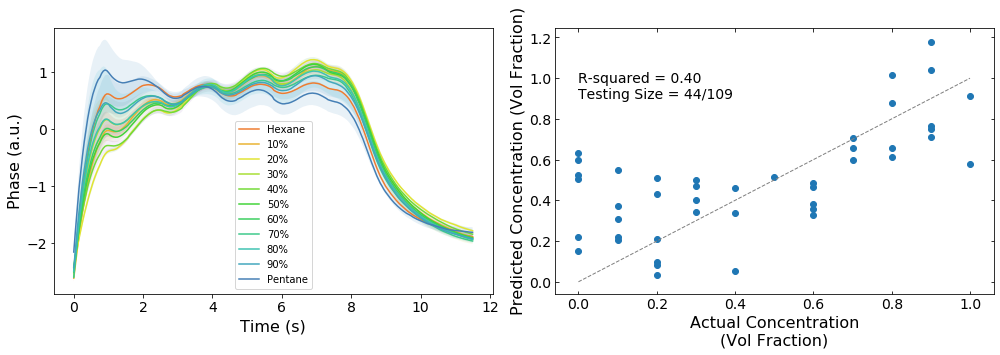

In [194]:
fig,ax = plt.subplots(ncols = 2)
fig.set_size_inches([14,5])

# ========== PLOT REGRESSION ==========
dataset = PD[mixture]
    
for chem,values in lbls[mixture].items():
    if values:
        data = np.array([dataset[num] for num in values])

        avg = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax[0].plot(time[mixture], avg, label=transl_dict[chem], color=colors[chem])
        ax[0].fill_between(time[mixture], avg-std, avg+std, alpha=0.1)

        ax[0].legend(loc='lower center')
        
ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_xlabel('Time (s)', fontsize=labelsize)
ax[0].tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
        
# ========== PLOT REGRESSION ==========
ax[1].set_xlabel('Actual Concentration\n(Vol Fraction)', fontsize = labelsize)
ax[1].set_ylabel('Predicted Concentration (Vol Fraction)', fontsize = labelsize)
ax[1].tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

# plot line representing 1:1 correspondence
ax[1].plot(np.linspace(0,1.0,100),np.linspace(0,1.0,100),'--',c='gray',linewidth=1)

# scatter predictions
ax[1].scatter(test_lbl,predicted)
#ax[1].set_title("Regression of all {} mixtures".format(mixture))
ax[1].text(0, 0.9, 'R-squared = %0.2f\nTesting Size = %d/%d' % (SVR.score(test, test_lbl),len(test),len(train)+len(test)), fontsize=14)

fig.tight_layout()
fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing C5C6 - short.svg', format='svg', dpi=1200)

##### Pentane-Octane

In [218]:
mixt_dict = dict([('OCTANE',0), ('1C5-9C8',0.1), ('2C5-8C8',0.2), ('3C5-7C8',0.3), ('4C5-6C8',0.4), ('5C5-5C8',0.5), ('6C5-4C8',0.6), ('7C5-3C8',0.7), ('8C5-2C8',0.8), ('9C5-1C8',0.9), ('PENTANE',1.0)])

col = get_gradient_colors(len(mixt_dict),color_dict[list(mixt_dict.keys())[0].capitalize()], color_dict[list(mixt_dict.keys())[-1].capitalize()])
colors = {}
for n,key in enumerate(mixt_dict.keys()):
    colors[key] = col[n]

In [219]:
transl_dict = dict([('OCTANE','Octane'), ('1C5-9C8','10%'), ('2C5-8C8','20%'), ('3C5-7C8','30%'), ('4C5-6C8','40%'), ('5C5-5C8','50%'), ('6C5-4C8','60%'), ('7C5-3C8','70%'), ('8C5-2C8','80%'), ('9C5-1C8','90%'), ('PENTANE','Pentane')])

In [220]:
# ========== MACHINE LEARNING ==========

mixture = "PENT+OCT"

data = list(PD[mixture].values())
labels = [mixt_dict[conc] for conc in list(num_to_lbl[mixture].values())]

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVR = clf.best_estimator_

# Perform training and testing
predicted = SVR.predict(test)

print("Training accuracy: {} ({})".format(round(SVR.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVR.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (64)
Validation accuracy: 0.8848983095558511 (44)


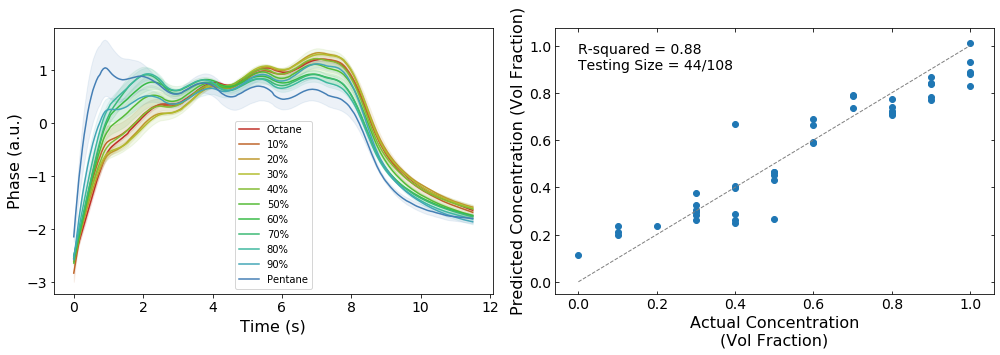

In [221]:
fig,ax = plt.subplots(ncols = 2)
fig.set_size_inches([14,5])

# ========== PLOT REGRESSION ==========
dataset = PD[mixture]
    
for chem,values in lbls[mixture].items():
    if values:
        data = np.array([dataset[num] for num in values])

        avg = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax[0].plot(time[mixture], avg, label=transl_dict[chem],color=colors[chem])
        ax[0].fill_between(time[mixture], avg-std, avg+std, alpha=0.1,color=colors[chem])

        ax[0].legend(loc='lower center')

ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_xlabel('Time (s)', fontsize=labelsize)
ax[0].tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
        
# ========== PLOT REGRESSION ==========
ax[1].set_xlabel('Actual Concentration\n(Vol Fraction)', fontsize = labelsize)
ax[1].set_ylabel('Predicted Concentration (Vol Fraction)', fontsize = labelsize)
ax[1].tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

# plot line representing 1:1 correspondence
ax[1].plot(np.linspace(0,1.0,100),np.linspace(0,1.0,100),'--',c='gray',linewidth=1)

# scatter predictions
ax[1].scatter(test_lbl,predicted)
#ax[1].set_title("Regression of all {} mixtures".format(mixture))
ax[1].text(0, 0.9, 'R-squared = %0.2f\nTesting Size = %d/%d' % (SVR.score(test, test_lbl),len(test),len(train)+len(test)), fontsize=14)

fig.tight_layout()
fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing C5C8 - short.svg', format='svg', dpi=1200)

##### Ethanol-Water

In [200]:
mixt_dict = dict([('ETHANOL',0), ('1W-9ET',0.1), ('2W-8ET',0.2), ('3W-7ET',0.3), ('4W-6ET',0.4), ('5W-5ET',0.5), ('6W-4ET',0.6), ('7W-3ET',0.7), ('8W-2ET',0.8), ('9W-1ET',0.9), ('WATER',1.0)])

col = get_gradient_colors(len(mixt_dict),color_dict[list(mixt_dict.keys())[0].capitalize()], color_dict[list(mixt_dict.keys())[-1].capitalize()])
colors = {}
for n,key in enumerate(mixt_dict.keys()):
    colors[key] = col[n]

In [201]:
transl_dict = dict([('ETHANOL',"Ethanol"), ('1W-9ET',"10%"), ('2W-8ET',"20%"), ('3W-7ET',"30%"), ('4W-6ET',"40%"), ('5W-5ET',"50%"), ('6W-4ET',"60%"), ('7W-3ET',"70%"), ('8W-2ET',"80%"), ('9W-1ET',"90%"), ('WATER',"Water")])

In [202]:
# ========== MACHINE LEARNING ==========

mixture = "WATER+ETOH"

data = list(PD[mixture].values())
labels = [mixt_dict[conc] for conc in list(num_to_lbl[mixture].values())]

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVR = clf.best_estimator_

# Perform training and testing
predicted = SVR.predict(test)

print("Training accuracy: {} ({})".format(round(SVR.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVR.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (66)
Validation accuracy: 0.019024642081218786 (44)


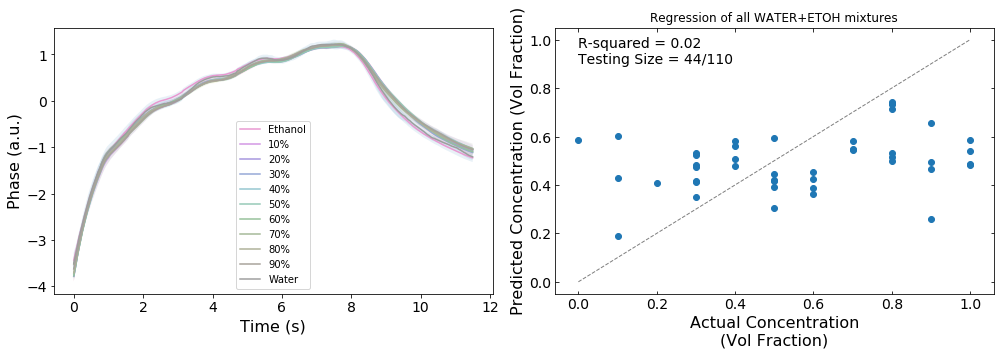

In [203]:
fig,ax = plt.subplots(ncols = 2)
fig.set_size_inches([14,5])

# ========== PLOT REGRESSION ==========
dataset = PD[mixture]
    
for chem,values in lbls[mixture].items():
    if values:
        data = np.array([dataset[num] for num in values])

        avg = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax[0].plot(time[mixture], avg, label=transl_dict[chem], color=colors[chem])
        ax[0].fill_between(time[mixture], avg-std, avg+std, alpha=0.1)

        ax[0].legend(loc='lower center')

ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_xlabel('Time (s)', fontsize=labelsize)
ax[0].tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
        
# ========== PLOT REGRESSION ==========
ax[1].set_xlabel('Actual Concentration\n(Vol Fraction)', fontsize = labelsize)
ax[1].set_ylabel('Predicted Concentration (Vol Fraction)', fontsize = labelsize)
ax[1].tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

# plot line representing 1:1 correspondence
ax[1].plot(np.linspace(0,1.0,100),np.linspace(0,1.0,100),'--',c='gray',linewidth=1)

# scatter predictions
ax[1].scatter(test_lbl,predicted)
ax[1].set_title("Regression of all {} mixtures".format(mixture))
ax[1].text(0, 0.9, 'R-squared = %0.2f\nTesting Size = %d/%d' % (SVR.score(test, test_lbl),len(test),len(train)+len(test)), fontsize=14)

fig.tight_layout()
fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing EtOH - short.svg', format='svg', dpi=1200)

#### Procedure 3: Deep sniff
Odorant: 5,
Break: 2.5,
Nitrogen: 5

In [204]:
PD = {}
num_to_lbl = {}
lbls = {}
time = {}

# ========== LOAD DATA ==========
mixture = "PENT+HEX"
PD[mixture], num_to_lbl[mixture], lbls[mixture], time[mixture] = regression_data(3, mixture_list=[mixture])

mixture = "PENT+OCT"
PD[mixture], num_to_lbl[mixture], lbls[mixture], time[mixture] = regression_data(3, mixture_list=[mixture])

mixture = "WATER+ETOH"
PD[mixture], num_to_lbl[mixture], lbls[mixture], time[mixture] = regression_data(3, mixture_list=[mixture])

# Remove outliers
for key in PD.keys():
    remove_outliers(PD[key], list_to_remove)
    remove_outliers(num_to_lbl[key], list_to_remove)
    remove_outliers(lbls[key], list_to_remove)

20/20 done
10/10 done
81/81 done


##### Pentane-Hexane

In [205]:
mixt_dict = dict([('HEXANE',0), ('1C5-9C6',0.1), ('2C5-8C6',0.2), ('3C5-7C6',0.3), ('4C5-6C6',0.4), ('5C5-5C6',0.5), ('6C5-4C6',0.6), ('7C5-3C6',0.7), ('8C5-2C6',0.8), ('9C5-1C6',0.9), ('PENTANE',1.0)])

col = get_gradient_colors(len(mixt_dict),color_dict[list(mixt_dict.keys())[0].capitalize()], color_dict[list(mixt_dict.keys())[-1].capitalize()])
colors = {}
for n,key in enumerate(mixt_dict.keys()):
    colors[key] = col[n]

In [206]:
transl_dict = dict([('HEXANE','Hexane'), ('1C5-9C6','10%'), ('2C5-8C6','20%'), ('3C5-7C6','30%'), ('4C5-6C6','40%'), ('5C5-5C6','50%'), ('6C5-4C6','60%'), ('7C5-3C6','70%'), ('8C5-2C6','80%'), ('9C5-1C6','90%'), ('PENTANE','Pentane')])

In [207]:
# ========== MACHINE LEARNING ==========

mixture = "PENT+HEX"

data = list(PD[mixture].values())
labels = [mixt_dict[conc] for conc in list(num_to_lbl[mixture].values())]

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVR = clf.best_estimator_

# Perform training and testing
predicted = SVR.predict(test)

print("Training accuracy: {} ({})".format(round(SVR.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVR.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (12)
Validation accuracy: 0.9401640694533357 (8)


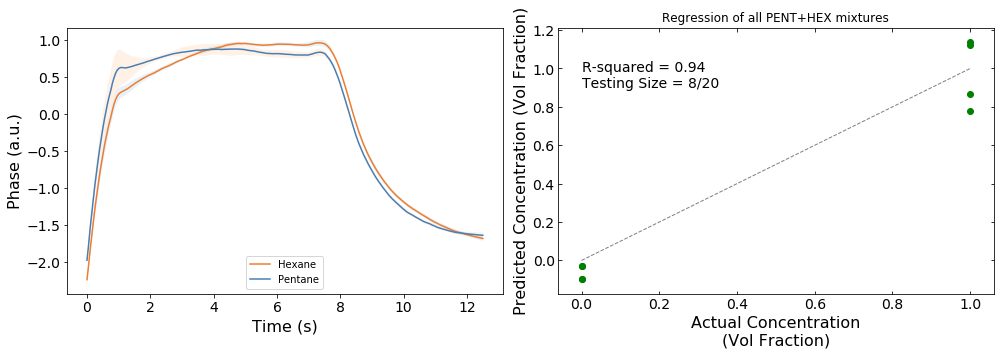

In [208]:
fig,ax = plt.subplots(ncols = 2)
fig.set_size_inches([14,5])

# ========== PLOT REGRESSION ==========
dataset = PD[mixture]
    
for chem,values in lbls[mixture].items():
    if values:
        data = np.array([dataset[num] for num in values])

        avg = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax[0].plot(time[mixture], avg, label=transl_dict[chem], color=colors[chem])
        ax[0].fill_between(time[mixture], avg-std, avg+std, alpha=0.1)

        ax[0].legend(loc='lower center')

ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_xlabel('Time (s)', fontsize=labelsize)
ax[0].tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
        
# ========== PLOT REGRESSION ==========
ax[1].set_xlabel('Actual Concentration\n(Vol Fraction)', fontsize = labelsize)
ax[1].set_ylabel('Predicted Concentration (Vol Fraction)', fontsize = labelsize)
ax[1].tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

# plot line representing 1:1 correspondence
ax[1].plot(np.linspace(0,1.0,100),np.linspace(0,1.0,100),'--',c='gray',linewidth=1)

# scatter predictions
ax[1].scatter(test_lbl,predicted,c='g')
ax[1].set_title("Regression of all {} mixtures".format(mixture))
ax[1].text(0, 0.9, 'R-squared = %0.2f\nTesting Size = %d/%d' % (SVR.score(test, test_lbl),len(test),len(train)+len(test)), fontsize=14)

fig.tight_layout()

##### Pentane-Octane

In [209]:
mixt_dict = dict([('OCTANE',0), ('1C5-9C8',0.1), ('2C5-8C8',0.2), ('3C5-7C8',0.3), ('4C5-6C8',0.4), ('5C5-5C8',0.5), ('6C5-4C8',0.6), ('7C5-3C8',0.7), ('8C5-2C8',0.8), ('9C5-1C8',0.9), ('PENTANE',1.0)])

col = get_gradient_colors(len(mixt_dict),color_dict[list(mixt_dict.keys())[0].capitalize()], color_dict[list(mixt_dict.keys())[-1].capitalize()])
colors = {}
for n,key in enumerate(mixt_dict.keys()):
    colors[key] = col[n]

In [210]:
transl_dict = dict([('OCTANE','Octane'), ('1C5-9C8','10%'), ('2C5-8C8','20%'), ('3C5-7C8','30%'), ('4C5-6C8','40%'), ('5C5-5C8','50%'), ('6C5-4C8','60%'), ('7C5-3C8','70%'), ('8C5-2C8','80%'), ('9C5-1C8','90%'), ('PENTANE','Pentane')])

In [211]:
# ========== MACHINE LEARNING ==========

mixture = "PENT+OCT"

data = list(PD[mixture].values())
labels = [mixt_dict[conc] for conc in list(num_to_lbl[mixture].values())]

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVR = clf.best_estimator_

# Perform training and testing
predicted = SVR.predict(test)

print("Training accuracy: {} ({})".format(round(SVR.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVR.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1 (6)
Validation accuracy: 1.0 (4)


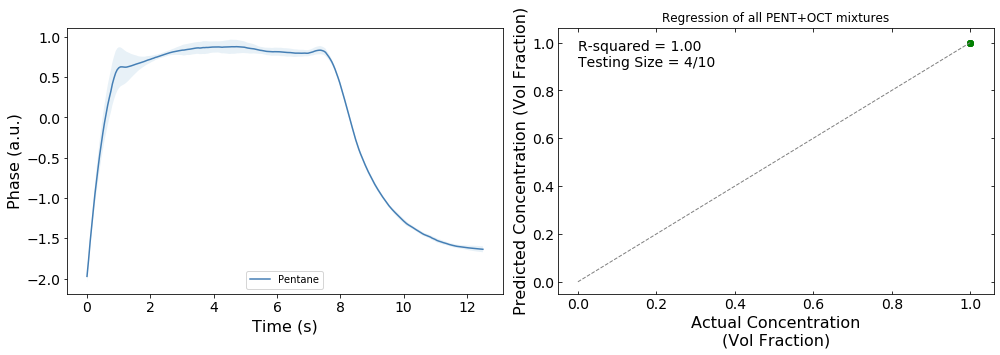

In [212]:
fig,ax = plt.subplots(ncols = 2)
fig.set_size_inches([14,5])

# ========== PLOT REGRESSION ==========
dataset = PD[mixture]
    
for chem,values in lbls[mixture].items():
    if values:
        data = np.array([dataset[num] for num in values])

        avg = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax[0].plot(time[mixture], avg, label=transl_dict[chem], color=colors[chem])
        ax[0].fill_between(time[mixture], avg-std, avg+std, alpha=0.1)

        ax[0].legend(loc='lower center')

ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_xlabel('Time (s)', fontsize=labelsize)
ax[0].tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
        
# ========== PLOT REGRESSION ==========
ax[1].set_xlabel('Actual Concentration\n(Vol Fraction)', fontsize = labelsize)
ax[1].set_ylabel('Predicted Concentration (Vol Fraction)', fontsize = labelsize)
ax[1].tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

# plot line representing 1:1 correspondence
ax[1].plot(np.linspace(0,1.0,100),np.linspace(0,1.0,100),'--',c='gray',linewidth=1)

# scatter predictions
ax[1].scatter(test_lbl,predicted,c='g')
ax[1].set_title("Regression of all {} mixtures".format(mixture))
ax[1].text(0, 0.9, 'R-squared = %0.2f\nTesting Size = %d/%d' % (SVR.score(test, test_lbl),len(test),len(train)+len(test)), fontsize=14)

fig.tight_layout()

##### Ethanol-Water

In [213]:
mixt_dict = dict([('ETHANOL',0), ('1W-9ET',0.1), ('2W-8ET',0.2), ('3W-7ET',0.3), ('4W-6ET',0.4), ('5W-5ET',0.5), ('6W-4ET',0.6), ('7W-3ET',0.7), ('8W-2ET',0.8), ('9W-1ET',0.9), ('WATER',1.0)])

col = get_gradient_colors(len(mixt_dict),color_dict[list(mixt_dict.keys())[0].capitalize()], color_dict[list(mixt_dict.keys())[-1].capitalize()])
colors = {}
for n,key in enumerate(mixt_dict.keys()):
    colors[key] = col[n]

In [214]:
transl_dict = dict([('ETHANOL',"Ethanol"), ('1W-9ET',"10%"), ('2W-8ET',"20%"), ('3W-7ET',"30%"), ('4W-6ET',"40%"), ('5W-5ET',"50%"), ('6W-4ET',"60%"), ('7W-3ET',"70%"), ('8W-2ET',"80%"), ('9W-1ET',"90%"), ('WATER',"Water")])

In [215]:
# ========== MACHINE LEARNING ==========

mixture = "WATER+ETOH"

data = list(PD[mixture].values())
labels = [mixt_dict[conc] for conc in list(num_to_lbl[mixture].values())]

# Split data into train and test. Default test size = 40%. Choose a seed for random state.
train, test, train_lbl, test_lbl = tts(data, labels, test_size=0.4, random_state=seed) # train_test_split as tts

# ========== CLASSIFICATION ==========

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':[1e-4, 1e-2, 1, 1e2, 1e4], 'gamma':[0.1, 1, 10]}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)

# Perform 1st grid search using GridSearchCV as gs
parameters = {'C':np.array([0.2, 0.5, 1, 2, 5])*clf.best_params_['C'], 'gamma':np.array([0.5, 1, 2])*clf.best_params_['gamma']}
clf = gs(svm.SVR(kernel='rbf'), parameters, cv=3, iid='False') # GridSearchCV as gs
clf.fit(train, train_lbl)
SVR = clf.best_estimator_

# Perform training and testing
predicted = SVR.predict(test)

print("Training accuracy: {} ({})".format(round(SVR.score(train, train_lbl)),len(train_lbl)))
print("Validation accuracy: {} ({})".format(SVR.score(test, test_lbl),len(test_lbl)))

Training accuracy: 1.0 (48)
Validation accuracy: 0.5869431827723232 (33)


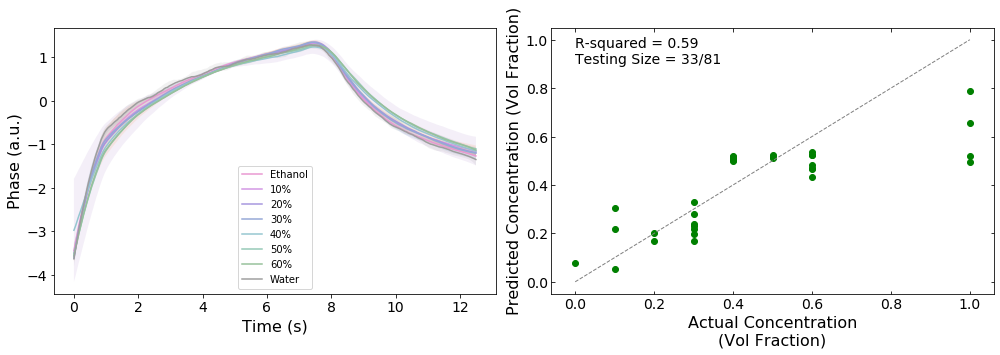

In [216]:
fig,ax = plt.subplots(ncols = 2)
fig.set_size_inches([14,5])

# ========== PLOT REGRESSION ==========
dataset = PD[mixture]
    
for chem,values in lbls[mixture].items():
    if values:
        data = np.array([dataset[num] for num in values])

        avg = np.mean(data, axis=0)
        std = np.std(data, axis=0)

        ax[0].plot(time[mixture], avg, label=transl_dict[chem], color=colors[chem])
        ax[0].fill_between(time[mixture], avg-std, avg+std, alpha=0.1)

        ax[0].legend(loc='lower center')

ax[0].set_ylabel('Phase (a.u.)', fontsize=labelsize)
ax[0].set_xlabel('Time (s)', fontsize=labelsize)
ax[0].tick_params(direction='out', top = False, bottom = True, left = True, right = False, labelsize = ticksize)
        
# ========== PLOT REGRESSION ==========
ax[1].set_xlabel('Actual Concentration\n(Vol Fraction)', fontsize = labelsize)
ax[1].set_ylabel('Predicted Concentration (Vol Fraction)', fontsize = labelsize)
ax[1].tick_params(direction='in', top = True, bottom = True, left = True, right = True, labelsize = ticksize)

# plot line representing 1:1 correspondence
ax[1].plot(np.linspace(0,1.0,100),np.linspace(0,1.0,100),'--',c='gray',linewidth=1)

# scatter predictions
ax[1].scatter(test_lbl,predicted,c='g')
#ax[1].set_title("Regression of all {} mixtures".format(mixture))
ax[1].text(0, 0.9, 'R-squared = %0.2f\nTesting Size = %d/%d' % (SVR.score(test, test_lbl),len(test),len(train)+len(test)), fontsize=14)

fig.tight_layout()
fig.savefig('../../../../../../Macintosh HD/Users/Soren/Desktop/Sniffing EtOH - deep.svg', format='svg', dpi=1200)